In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.image_classification.controller.trainer_inception import InceptionTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.inception import GoogLeNet
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/inception")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
DEVICE = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
NUM_CLASS = 43

In [9]:
len(train_dataset)

26640

25


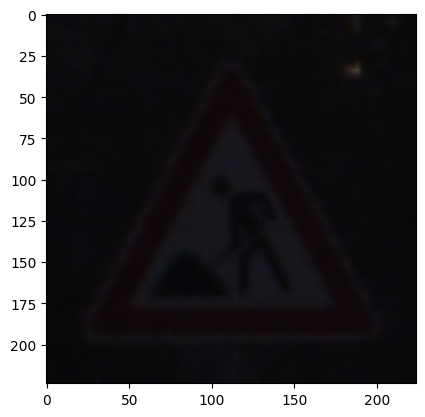

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [ ]:
model = GoogLeNet(output_size=NUM_CLASS).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
Inception                                               --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 9,472
│    │    └─ReLU: 3-2                                   --
│    └─MaxPool2d: 2-2                                   --
│    └─Conv2dNormActivation: 2-3                        --
│    │    └─Conv2d: 3-3                                 4,160
│    │    └─ReLU: 3-4                                   --
│    └─Conv2dNormActivation: 2-4                        --
│    │    └─Conv2d: 3-5                                 110,784
│    │    └─ReLU: 3-6                                   --
│    └─MaxPool2d: 2-5                                   --
├─Sequential: 1-2                                       --
│    └─InceptionBlock: 2-6                              --
│    │    └─ModuleList: 3-7             

# training

In [13]:
EPOCHS = 10
ACC_ITERS = 1

In [14]:
trainer = InceptionTrainer(EPOCHS, DEVICE, ACC_ITERS)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

Enable AMP: False
Training...


100%|██████████| 416/416 [01:32<00:00,  4.51it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.5661e-01 (0.00%)


100%|██████████| 416/416 [01:25<00:00,  4.89it/s]


------------------------------------
Epoch 2
------------------------------------
total: 1.0626e-01 (-32.00%)


100%|██████████| 416/416 [02:06<00:00,  3.28it/s]


------------------------------------
Epoch 3
------------------------------------
total: 7.2554e-02 (-32.00%)


100%|██████████| 416/416 [02:06<00:00,  3.29it/s]


------------------------------------
Epoch 4
------------------------------------
total: 4.1130e-02 (-43.00%)


100%|██████████| 416/416 [01:53<00:00,  3.65it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.9198e-02 (-53.00%)


100%|██████████| 416/416 [01:58<00:00,  3.51it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.1299e-02 (-41.00%)


100%|██████████| 416/416 [01:50<00:00,  3.76it/s]


------------------------------------
Epoch 7
------------------------------------
total: 7.4744e-03 (-34.00%)


100%|██████████| 416/416 [01:45<00:00,  3.95it/s]


------------------------------------
Epoch 8
------------------------------------
total: 6.2073e-03 (-17.00%)


100%|██████████| 416/416 [01:44<00:00,  3.97it/s]


------------------------------------
Epoch 9
------------------------------------
total: 4.8071e-03 (-23.00%)


100%|██████████| 416/416 [01:14<00:00,  5.55it/s]

------------------------------------
Epoch 10
------------------------------------
total: 3.9910e-03 (-17.00%)


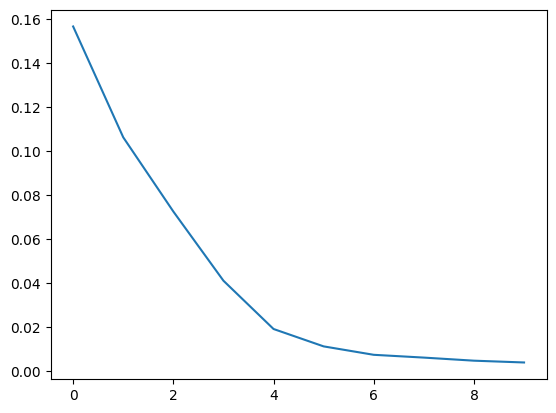

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [03:00<00:00,  1.10it/s]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(NUM_CLASS), per_class_acc)

0         : 0.3
1         : 0.9791666666666666
2         : 0.9893333333333333
3         : 0.9
4         : 0.9742424242424242
5         : 0.9015873015873016
6         : 0.8666666666666667
7         : 0.9666666666666667
8         : 0.9355555555555556
9         : 1.0
10        : 0.9681818181818181
11        : 0.9214285714285714
12        : 0.9130434782608695
13        : 0.8958333333333334
14        : 1.0
15        : 0.9666666666666667
16        : 1.0
17        : 0.9083333333333333
18        : 0.9564102564102565
19        : 1.0
20        : 0.34444444444444444
21        : 0.6444444444444445
22        : 0.7833333333333333
23        : 0.9333333333333333
24        : 0.9333333333333333
25        : 0.925
26        : 0.9944444444444445
27        : 0.5833333333333334
28        : 0.9933333333333333
29        : 1.0
30        : 0.6866666666666666
31        : 0.9037037037037037
32        : 1.0
33        : 0.7333333333333333
34        : 0.5083333333333333
35        : 0.8051282051282052
36        : 0.74

In [24]:
per_class_acc.mean()

np.float64(0.8360732762724673)

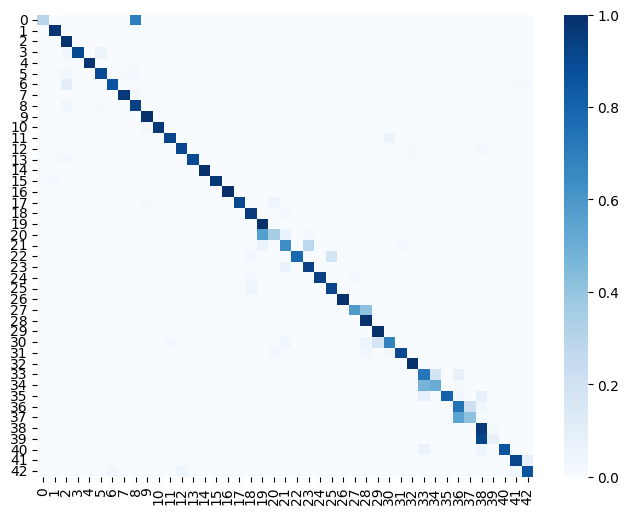

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(NUM_CLASS),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'inception.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'24.86MiB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>